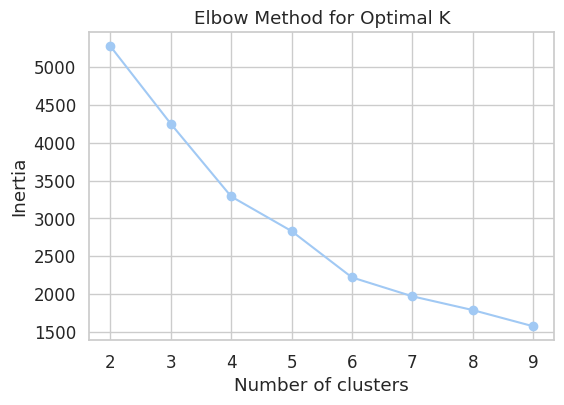

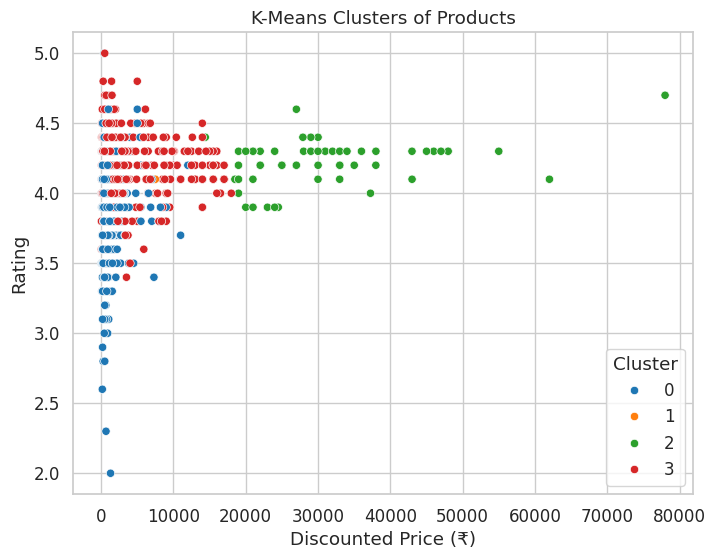

R²: 0.2973333985229797
MAE: 3456.254445220786


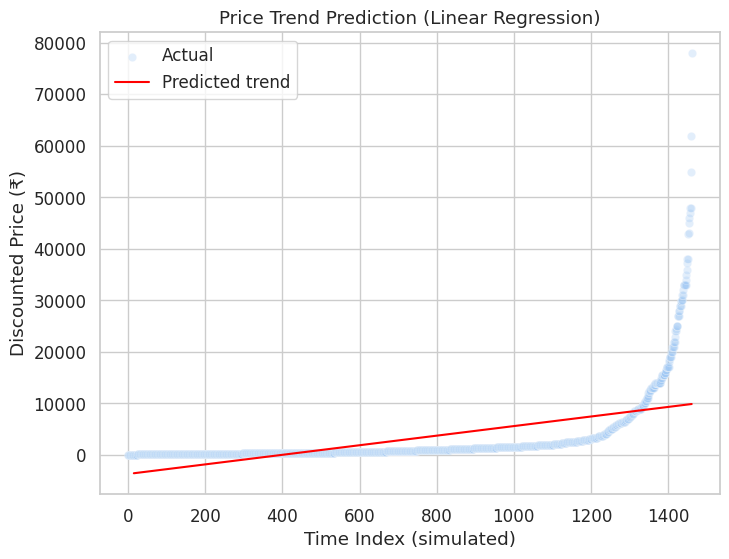

In [4]:
# MACHINE LEARNING ANALYSIS
# -------------------------
# Goal: cluster similar products and predict price trends

# Step 1. Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import re

sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Step 2. Load and clean data
df = pd.read_csv('/content/amazon.csv')

def to_number_currency(s):
    if pd.isna(s): return np.nan
    s = re.sub(r"[^0-9.]", "", str(s))
    try: return float(s)
    except: return np.nan

def to_number_pct(s):
    if pd.isna(s): return np.nan
    s = re.sub(r"[^0-9.]", "", str(s))
    try: return float(s)
    except: return np.nan

# Convert numeric fields
df['discounted_price_num'] = df['discounted_price'].apply(to_number_currency)
df['actual_price_num'] = df['actual_price'].apply(to_number_currency)
df['discount_pct_num'] = df['discount_percentage'].apply(to_number_pct)
df['rating_num'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count_num'] = pd.to_numeric(df['rating_count'].str.replace(',', ''), errors='coerce')

# Drop rows with too many missing values
df = df.dropna(subset=['discounted_price_num','actual_price_num','discount_pct_num','rating_num','rating_count_num'])

# ---------------------------------------------------------------------------
# PART 1 — K-MEANS CLUSTERING
# ---------------------------------------------------------------------------

# Select features for clustering
features = df[['discounted_price_num', 'actual_price_num', 'discount_pct_num', 'rating_num', 'rating_count_num']]

# Standardize data
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# Elbow method to choose optimal number of clusters
inertia = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Fit final model (choose K=4, can adjust)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled)

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='discounted_price_num', y='rating_num', hue='cluster', palette='tab10')
plt.title("K-Means Clusters of Products")
plt.xlabel("Discounted Price (₹)")
plt.ylabel("Rating")
plt.legend(title='Cluster')
plt.show()

# ---------------------------------------------------------------------------
# PART 2 — LINEAR REGRESSION (PRICE TREND PREDICTION)
# ---------------------------------------------------------------------------

# Simulate a time variable (since dataset has no real dates)
df = df.sort_values('discounted_price_num').reset_index(drop=True)
df['time_index'] = np.arange(len(df))

# Prepare data
X = df[['time_index']]
y = df['discounted_price_num']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate model
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Plot trend line
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['time_index'], y=df['discounted_price_num'], alpha=0.3, label='Actual')
sns.lineplot(x=X_test['time_index'], y=y_pred, color='red', label='Predicted trend')
plt.title("Price Trend Prediction (Linear Regression)")
plt.xlabel("Time Index (simulated)")
plt.ylabel("Discounted Price (₹)")
plt.legend()
plt.show()